In [ ]:
# ==== Install Libraries ====
!pip install ipdb
!pip install pettingzoo
# -*- coding: utf-8 -*-
# ==== Import Libraries ====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import gym
from gym import spaces
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.optimizers import Adam
import torch
from pettingzoo.utils.env import ParallelEnv
from tqdm import tqdm
import ipdb

# ==== Define the Grid World ====
class Hierarchy_Grid(ParallelEnv):
    metadata = {
        "name": "Hierarchy Grid",
    }

    def __init__(self, grid_size, num_agents, num_food, max_iter):
        self.timestep = None
        self.grid_size = grid_size
        self.possible_agents = np.arange(num_agents)
        self.num_food = num_food
        self.agents = np.arange(num_agents)
        self.max_iter = max_iter
        self.agent_positions = None
        self.fight_probs = {name: np.zeros(self.num_agents) for name in self.agents}
        self.rewards = {name: 0 for name in self.agents}

        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, self.num_agents + 1])
        self.action_space = spaces.Discrete(5)

        self.food_positions = []
        self.food_position_map = np.zeros((self.grid_size, self.grid_size))
        self.agent_position_maps = {}
        self.hit_bd = 0
        self.hit_seq = []

        self.fight_num = 0
        self.fight_seq = []

        self.food_comsum = 0
        self.good_game = False

    def update_hit(self):
      self.hit_seq.append(self.hit_bd)
      self.hit_bd = 0

    def update_fight(self):
      self.fight_seq.append(self.fight_num)
      self.fight_num = 0

    def reset(self):
        self.timestep = 0
        self.good_game = False
        self.num_fights = 0

        self.agent_positions = {}
        self.agent_position_maps = {}
        for agent in self.agents:
            #ipdb.set_trace(context=6)
            agent_position = np.random.randint(0, self.grid_size, 2)
            self.agent_positions[agent] = agent_position

            agent_position_map = np.zeros((self.grid_size, self.grid_size))
            agent_position_map[agent_position[0], agent_position[1]] = 1
            self.agent_position_maps[agent] = agent_position_map
        #ipdb.set_trace(context=6)
        self.food_positions = []
        self.food_position_map = np.zeros((self.grid_size, self.grid_size))
        for n in range(self.num_food):
          self.generate_food()

        observations = np.stack(self.agent_position_maps.values())
        #ipdb.set_trace(context=6)
        observations = np.concatenate([observations, np.expand_dims(self.food_position_map, axis=0)], axis=0)
        observations = np.moveaxis(observations,0,-1)
        observations = np.expand_dims(observations, axis=0)

        observations = {name: observations for name in self.agents}
        return observations, {}

    def step(self, actions):

        self.timestep += 1
        self.rewards = {name: 0 for name in self.agents}

        for agent in self.agents:
            action = actions[agent]
            self.move_agent(agent, action)

        self.reward_from_food()

        self.several_on_food_tile()
        self.depl_food()
        for agent in self.agents:
            self.rewards[agent] -= 1
        if self.timestep > self.max_iter:
            terminations = {name: True for name in self.agents}
        else:
            terminations = {name: False for name in self.agents}

        observations = np.stack(self.agent_position_maps.values())
        observations = np.concatenate([observations, np.expand_dims(self.food_position_map, axis=0)], axis=0)
        observations = np.moveaxis(observations,0,-1)
        observations = np.expand_dims(observations, axis=0)
        observations = {name: observations for name in self.agents}

        return observations, self.rewards, terminations, _, {}

    def generate_food(self):
        new_tile = tuple(np.random.randint(0, self.grid_size, 2))
        while self.food_position_map[new_tile] != 0:
          ipdb.set_trace(context = 6)
          new_tile = np.random.randint(0, self.grid_size, 2)
        self.food_positions.append(new_tile)
        self.food_position_map[new_tile] = 5
        #debug: self.render()


    def depl_food(self):
        for agent in self.agents:
            agent_position = tuple(self.agent_positions[agent])
            if self.food_position_map[agent_position] > 0:# use > 0 is a risk here, I don't know why
                #print(self.food_position_map)
                self.food_position_map[agent_position] -= 1

                if self.food_position_map[agent_position] == 0:
                    self.food_positions = [tile for tile in self.food_positions if not np.array_equal(tile, agent_position)]
                #if len(self.food_positions) < self.num_food:
                    self.food_comsum += 1
                    self.generate_food()
                    self.good_game = True

    def move_agent(self, agent, action):
        # Move the agent based on the selected action
        x, y = self.agent_positions[agent]

        if action == 0:  # Up
            x -= 1
        elif action == 1:  # Down
            x += 1
        elif action == 2:  # Left
            y -= 1
        elif action == 3:  # Right
            y += 1
        elif action == 4:  # Stay
            pass

        # Check if the new position is within grid boundaries
        if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
            self.agent_positions[agent] = tuple([x, y])

            new_map = np.zeros((self.grid_size, self.grid_size))
            new_map[x, y] = 1
            self.agent_position_maps[agent] = new_map
        else:
          self.hit_bd += 1
          self.rewards[agent] -= 2

    def several_on_food_tile(self):

        for food_tile in self.food_positions:
            agents_on_tile = [agent for agent, position in self.agent_positions.items() if np.all(position == food_tile)]

            if len(agents_on_tile) > 1:

                pairs = zip(agents_on_tile[:-1], agents_on_tile[1:])

                for pair in pairs:

                    self.conflict(pair[0], pair[1])

    def conflict(self, agent1, agent2):

        print(f"Conflict happened between agents {agent1}, {agent2}")
        self.fight_num += 1
        def sig(x):
            return 1 / (1 + np.exp(-x))

        # Agents make decision to fight or leave
        # 1 == fight, 0 == leave
        decision1 = bool(np.random.binomial(1, sig(self.fight_probs[agent1][agent2])))
        decision2 = bool(np.random.binomial(1, sig(self.fight_probs[agent2][agent1])))

        # Outcome of fight is determined in case both decide to stay
        outcome = np.random.binomial(1, 0.5)
        if outcome == 0:
            outcome = -1

        if not (decision1):
            self.relocate_agent(agent1)
        if not (decision2):
            self.relocate_agent(agent2)

        reward_dict = {(False, False): (0, 0),
                       (True, False): (5, 0),
                       (False, True): (0, 5),
                       (True, True): (5 * outcome, 5 * np.delete([-1,1], outcome))}

        # Allocate rewards based on decisions and fight outcome
        reward1, reward2 = reward_dict[(decision1, decision2)]
        self.rewards[agent1] += reward1
        self.rewards[agent2] += reward2

        if decision1 and decision2:
            self.num_fights += 1

        # Update future staying probabilities
        lr = 0.01
        self.fight_probs[agent1][agent2] += lr * reward1 * (decision1 - sig(self.fight_probs[agent1][agent2]))
        self.fight_probs[agent2][agent1] += lr * reward2 * (decision2 - sig(self.fight_probs[agent2][agent1]))

    def reward_from_food(self):

        for food_tile in self.food_positions:
            #ipdb.set_trace(context = 6)
            agents_on_tile = [agent for agent, position in self.agent_positions.items() if np.all(position == food_tile)]

            for agent in agents_on_tile:
                self.rewards[agent] += 5


    def relocate_agent(self, agent):
        # Relocate the agent to an adjacent position
        agent_position = self.agent_positions[agent]

        valid_position = False
        step = 1
        while not valid_position:

            # Generate moves
            possible_moves = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]]) * step  # Right, Left, Down, Up

            # Check if any of new positions are valid (within gridworld and not already occupied)
            for move in possible_moves:
                new_position = tuple(map(sum, zip(agent_position, move)))

                if 0 <= new_position[0] < self.grid_size and 0 <= new_position[1] < self.grid_size:
                    if np.isin((1,2), list(env.agent_positions.values())).any():

                        valid_position = True
                        self.agent_positions[agent] = new_position
                        agent_position_map = np.zeros((self.grid_size, self.grid_size))
                        agent_position_map[new_position] = 1
                        self.agent_position_maps[agent] = agent_position_map

            step += 1

    def render(self):

        agent_position_map = sum(self.agent_position_maps.values())

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(0, self.grid_size, 1))
        ax.set_yticks(np.arange(0, self.grid_size, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(color='none', linestyle='-', linewidth=2)
        ax.imshow(np.zeros((self.grid_size, self.grid_size)), cmap='gray', vmin=0, vmax=1)

        for i in range(self.grid_size):
            for j in range(self.grid_size):
              food_count = int(self.food_position_map[i, j]*100)/100
              agent_count = int(agent_position_map[i, j])
              agents_at_position = [agent_id for agent_id, position in self.agent_positions.items() if tuple(position) == (i, j)]
              if food_count > 0 and agents_at_position:
                  # If both agent and food are at the same position
                  ax.add_patch(plt.Rectangle((j - 0.4, i - 0.4), 0.8, 0.8, color='purple', alpha=0.5))
                  agent_info = "\n".join([f"A:{agent_id}" for agent_id in agents_at_position])
                  ax.text(j, i, f"F:{food_count}\n{agent_info}", color='white', ha='center', va='center')
              elif food_count > 0:
                  ax.add_patch(plt.Rectangle((j - 0.4, i - 0.4), 0.8, 0.8, color='green', alpha=0.5))
                  ax.text(j, i, f"F:{food_count}", color='white', ha='center', va='center')
              elif agent_count > 0:
                  if agent_count > 1:
                      ax.add_patch(plt.Rectangle((j - 0.4, i - 0.4), 0.8, 0.8, color='red', alpha=0.5))
                      agent_info = "\n".join([f"A:{agent_id}" for agent_id in agents_at_position])
                      ax.text(j, i, agent_info, color='white', ha='center', va='center')
                  else:
                      ax.add_patch(plt.Rectangle((j - 0.4, i - 0.4), 0.8, 0.8, color='red', alpha=0.5))
                      ax.text(j, i, f"A:{agents_at_position[0]}", color='white', ha='center', va='center')
        ax.set_xlim(-0.5, self.grid_size-0.5)
        ax.set_ylim(-0.5, self.grid_size-0.5)
        ax.set_aspect('equal')  # Set the aspect ratio of the plot to 'equal'
        ax.set_facecolor('white')  # Set the background color of the plot to white

        plt.show()

# ---- register the calss ----
gym.register(
    id='Hierarchy_Grid',
    entry_point=Hierarchy_Grid,
    kwargs={'grid_size': 2, 'num_agents': 1, 'num_food': 1,'max_iter': 1000}
)

# ==== Define the DQN agents ====
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # discount rate
        self.epsilon = 0.8 # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001
        self.loss = []
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32,name='input',kernel_size=(1, 1), input_shape=self.state_shape))
        model.add(Flatten(name='Flatten'))
        model.add(Dense(self.action_size, activation='linear', name='output'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):  # action selection, epsilon-greedy.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state,verbose=0)
        return np.argmax(act_values[0])

    def update(self, state, action, reward, next_state):
        target = reward + self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
        target_f = self.model.predict(state,verbose=0)
        target_f[0][action] = target

        history = self.model.fit(state, target_f, epochs=1, verbose=0)
        loss = history.history['loss'][0]
        self.loss.append(loss)

    def update_eps(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            print(self.epsilon)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.7/826.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 9.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/ker

0.76


/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:52: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  step_returns = self.env.step(action)
  1%|          | 1/125 [00:33<1:08:50, 33.31s/it]/usr/local/lib/python3.10/dist-packages/gym/core.py:415: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self.env.reset(**kwargs)


0.722


  2%|▏         | 2/125 [00:49<47:37, 23.23s/it]  

0.6859


  2%|▏         | 3/125 [01:06<41:03, 20.19s/it]

0.6516049999999999


  3%|▎         | 4/125 [01:22<37:25, 18.56s/it]

0.6190247499999999


  4%|▍         | 5/125 [01:40<36:49, 18.41s/it]

0.5880735124999998


  5%|▍         | 6/125 [01:59<36:57, 18.64s/it]

0.5586698368749998


  6%|▌         | 7/125 [02:15<35:15, 17.93s/it]

0.5307363450312498


  6%|▋         | 8/125 [02:32<34:10, 17.53s/it]

0.5041995277796872


  7%|▋         | 9/125 [02:51<34:37, 17.91s/it]

0.4789895513907029


  8%|▊         | 10/125 [03:09<34:25, 17.96s/it]

0.45504007382116773


  9%|▉         | 11/125 [03:27<34:04, 17.93s/it]

0.43228807013010934


 10%|▉         | 12/125 [03:44<33:09, 17.61s/it]

0.41067366662360383


 10%|█         | 13/125 [04:01<32:33, 17.44s/it]

0.3901399832924236


 11%|█         | 14/125 [04:21<33:44, 18.24s/it]

0.37063298412780243


 12%|█▏        | 15/125 [04:38<33:00, 18.00s/it]

0.3521013349214123


 13%|█▎        | 16/125 [04:57<33:04, 18.21s/it]

0.33449626817534167


 14%|█▎        | 17/125 [05:15<32:38, 18.13s/it]

0.3177714547665746


 14%|█▍        | 18/125 [05:35<33:28, 18.77s/it]

0.30188288202824587


 15%|█▌        | 19/125 [05:52<32:18, 18.29s/it]

0.28678873792683357


 16%|█▌        | 20/125 [06:11<32:14, 18.43s/it]

0.27244930103049186


 17%|█▋        | 21/125 [06:30<32:00, 18.46s/it]

0.2588268359789673


 18%|█▊        | 22/125 [06:49<32:16, 18.80s/it]

0.2458854941800189


 18%|█▊        | 23/125 [07:07<31:43, 18.67s/it]

0.23359121947101794


 19%|█▉        | 24/125 [07:25<31:05, 18.47s/it]

0.22191165849746702


 20%|██        | 25/125 [07:45<31:24, 18.85s/it]

0.21081607557259366


 21%|██        | 26/125 [08:08<33:03, 20.03s/it]

0.20027527179396395


 22%|██▏       | 27/125 [08:27<32:13, 19.73s/it]

0.19026150820426574


 22%|██▏       | 28/125 [08:47<32:05, 19.85s/it]

0.18074843279405245


 23%|██▎       | 29/125 [09:06<31:13, 19.52s/it]

0.1717110111543498


 24%|██▍       | 30/125 [09:28<32:00, 20.21s/it]

0.1631254605966323


 25%|██▍       | 31/125 [09:46<30:47, 19.65s/it]

0.15496918756680067


 26%|██▌       | 32/125 [10:06<30:35, 19.73s/it]

0.14722072818846063


 26%|██▋       | 33/125 [10:25<29:51, 19.47s/it]

0.1398596917790376


 27%|██▋       | 34/125 [10:47<30:41, 20.23s/it]

0.1328667071900857


 28%|██▊       | 35/125 [11:06<30:04, 20.05s/it]

0.1262233718305814


 29%|██▉       | 36/125 [11:26<29:20, 19.78s/it]

0.11991220323905233


 30%|██▉       | 37/125 [11:46<29:05, 19.84s/it]

0.11391659307709971


 30%|███       | 38/125 [12:06<29:06, 20.07s/it]

0.10822076342324471


 31%|███       | 39/125 [12:26<28:50, 20.12s/it]

0.10280972525208247


 32%|███▏      | 40/125 [12:47<28:35, 20.18s/it]

0.09766923898947834


 33%|███▎      | 41/125 [13:09<29:03, 20.75s/it]

0.09278577704000442


 34%|███▎      | 42/125 [13:30<28:50, 20.86s/it]

0.08814648818800419


 34%|███▍      | 43/125 [13:49<27:40, 20.25s/it]

0.08373916377860398


 35%|███▌      | 44/125 [14:09<27:21, 20.26s/it]

0.07955220558967377


 36%|███▌      | 45/125 [14:31<27:29, 20.62s/it]

0.07557459531019008


 37%|███▋      | 46/125 [14:50<26:45, 20.33s/it]

0.07179586554468056


 38%|███▊      | 47/125 [15:11<26:27, 20.35s/it]

0.06820607226744653


 38%|███▊      | 48/125 [15:30<25:38, 19.98s/it]

0.0647957686540742


 39%|███▉      | 49/125 [15:53<26:23, 20.83s/it]

0.06155598022137049


 40%|████      | 50/125 [16:13<26:03, 20.85s/it]

0.05847818121030196


 41%|████      | 51/125 [16:33<25:20, 20.55s/it]

0.05555427214978686


 42%|████▏     | 52/125 [16:54<24:57, 20.52s/it]

0.052776558542297514


 42%|████▏     | 53/125 [17:14<24:39, 20.55s/it]

0.05013773061518263


 43%|████▎     | 54/125 [17:34<24:08, 20.40s/it]

0.0476308440844235


 99%|█████████▉| 124/125 [41:17<00:20, 20.22s/it]/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


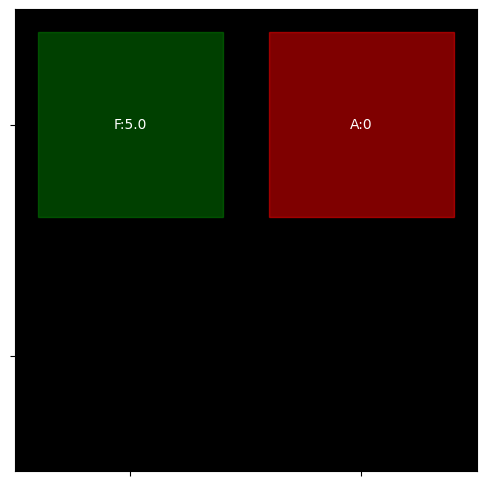

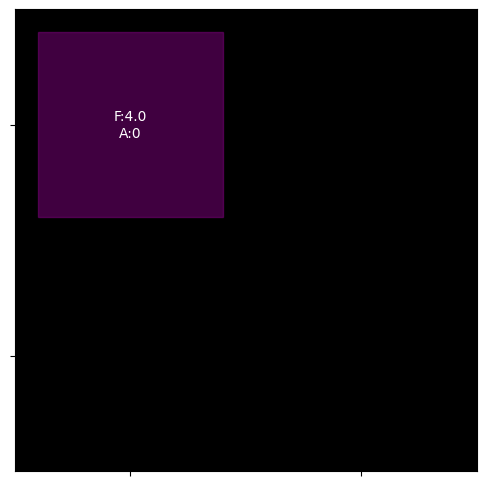

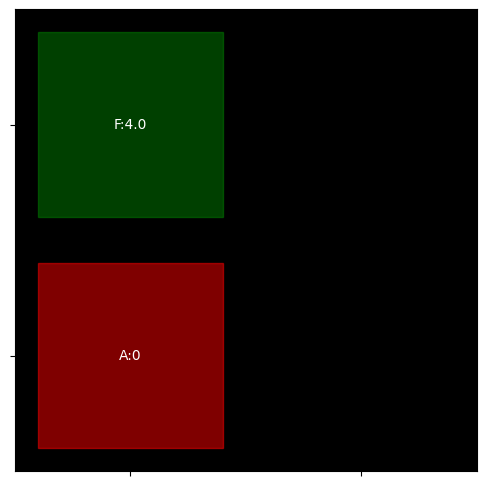

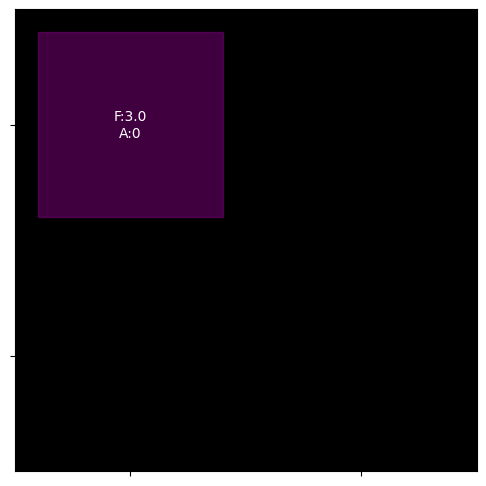

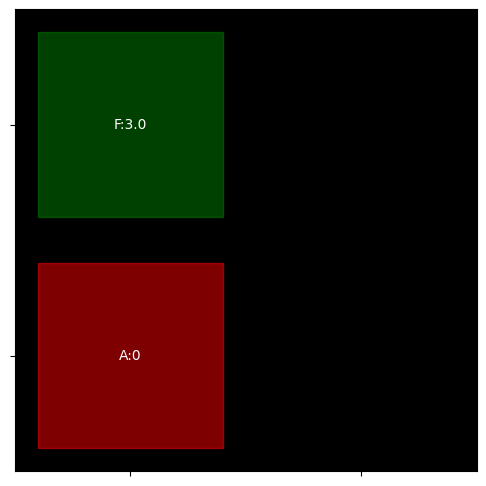

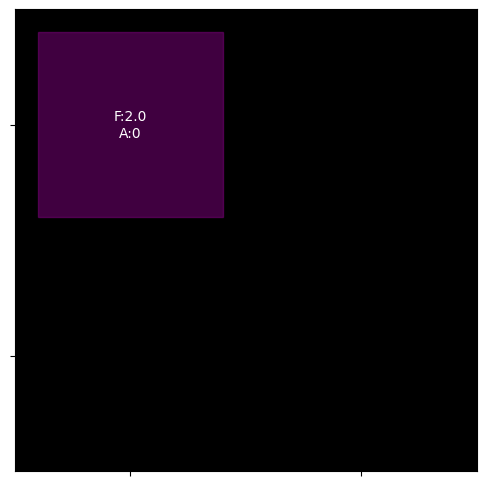

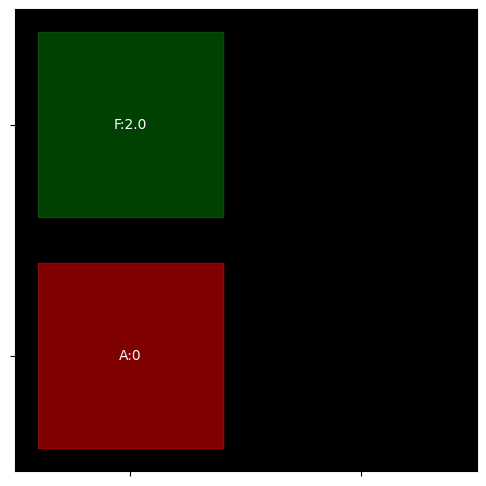

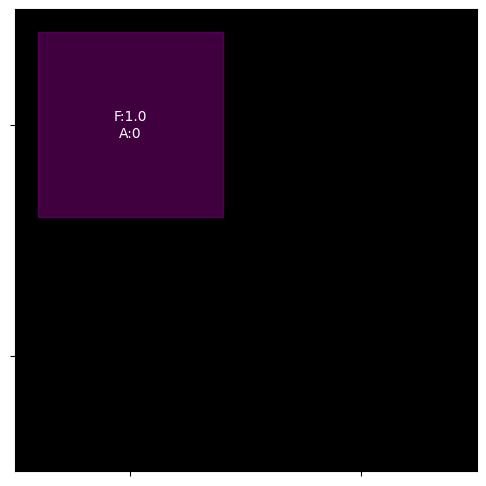

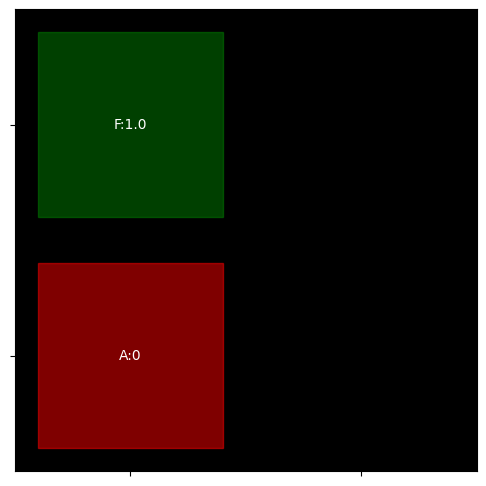

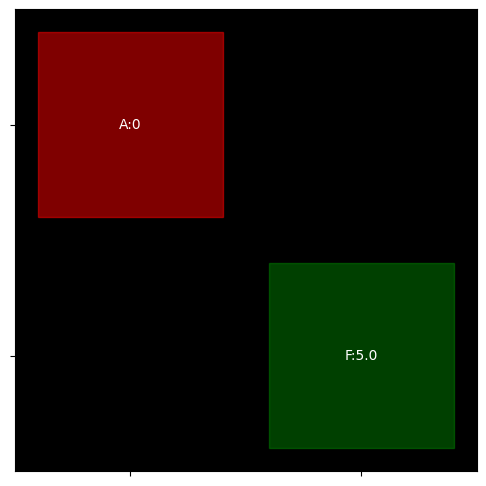

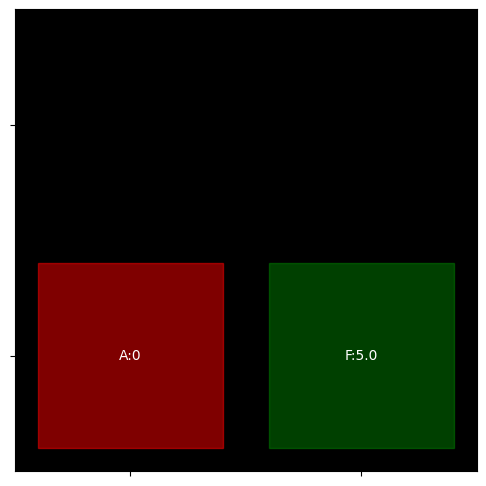

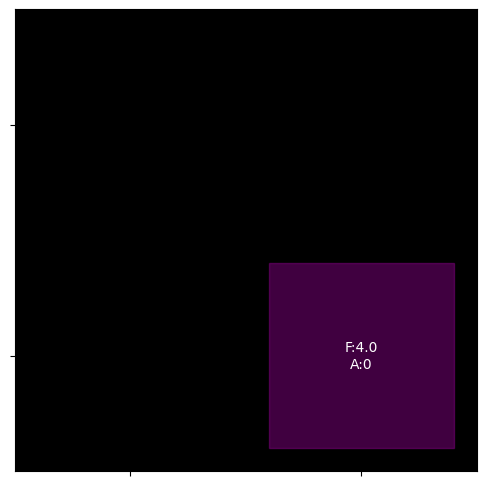

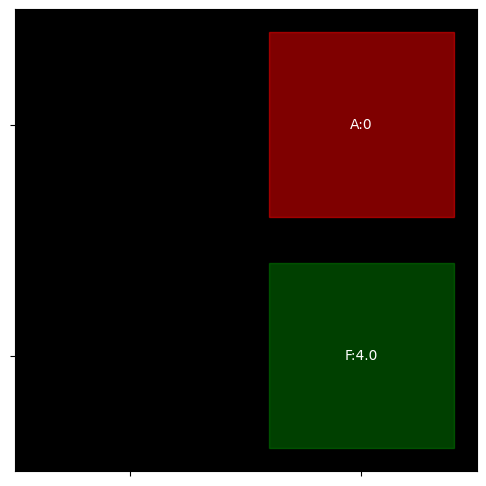

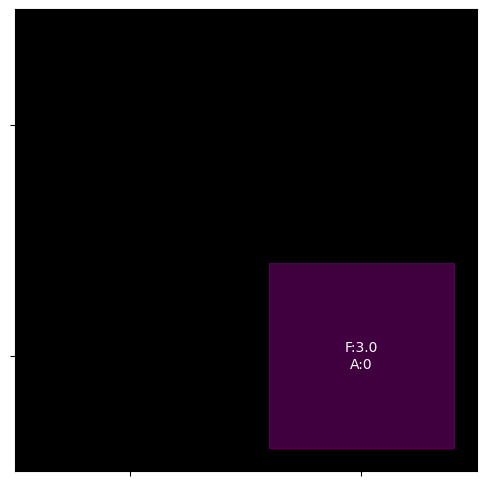

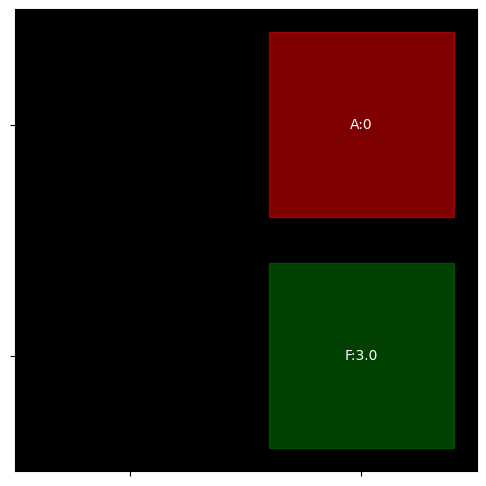

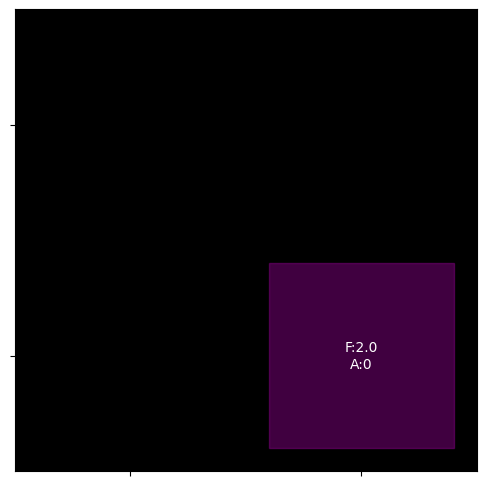

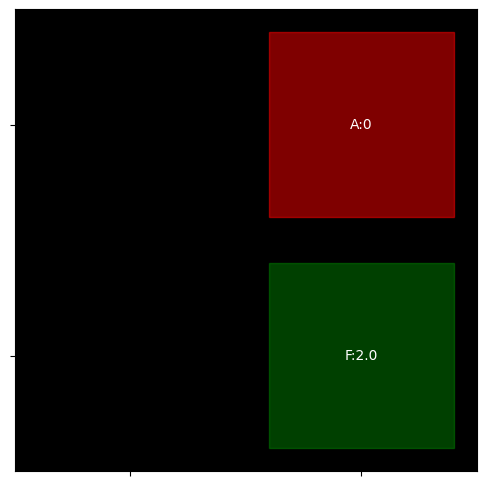

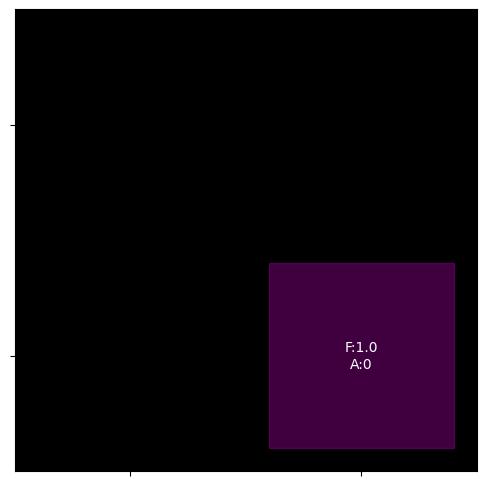

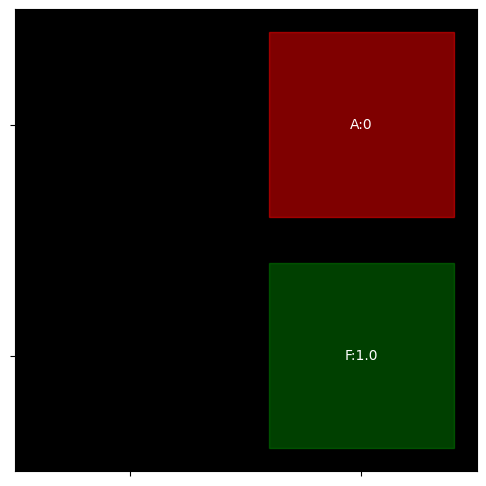

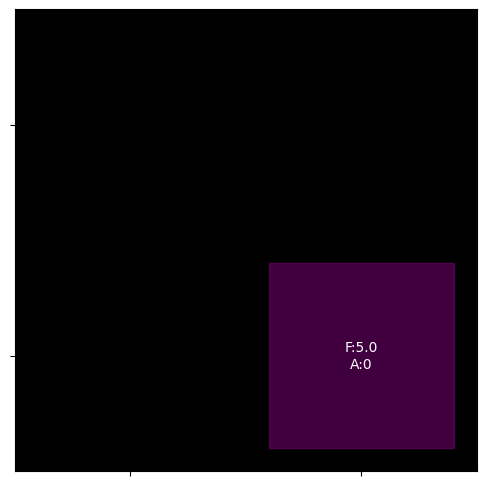

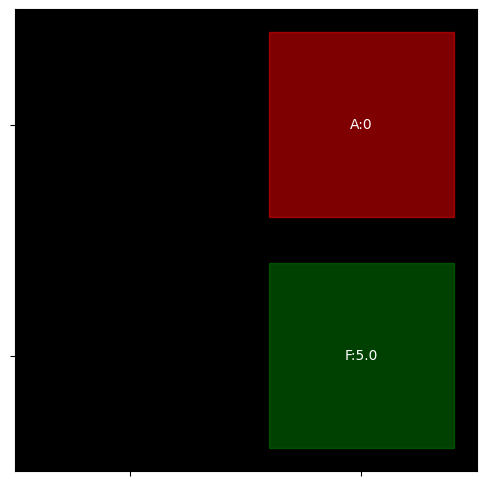

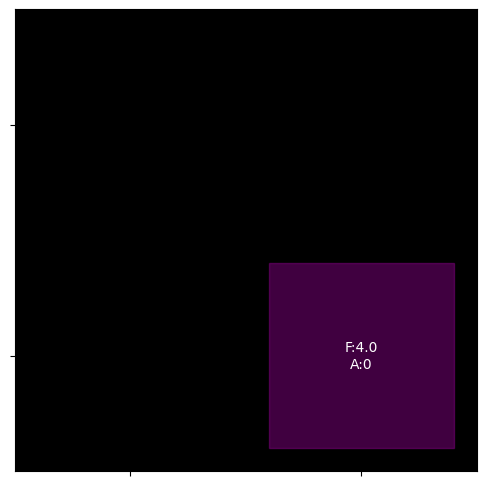

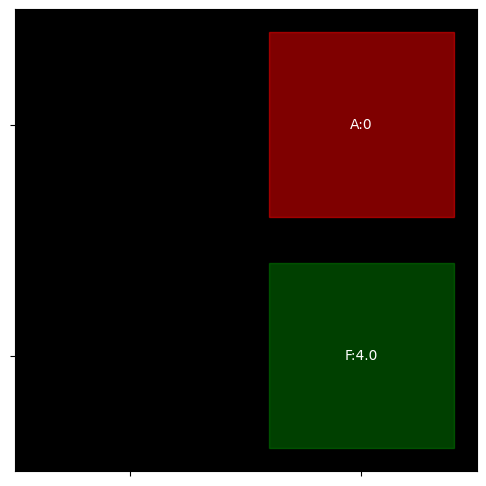

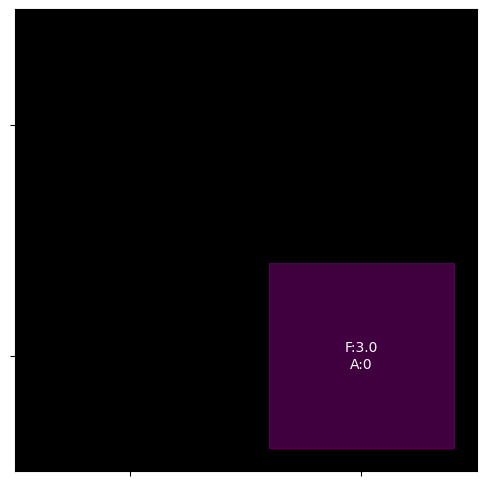

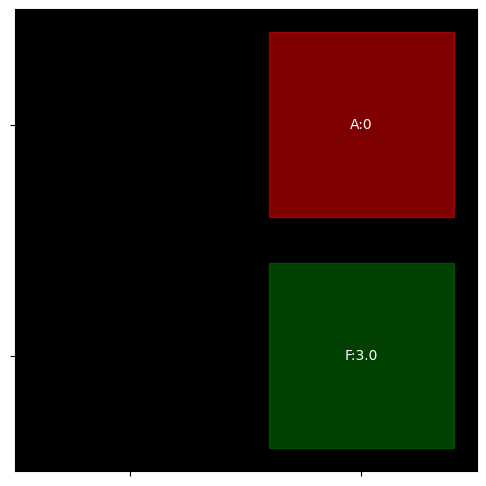

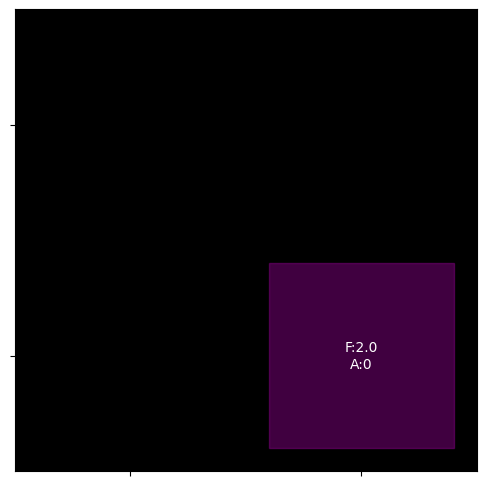

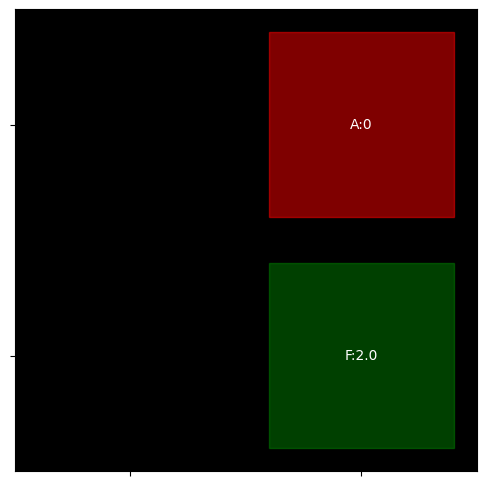

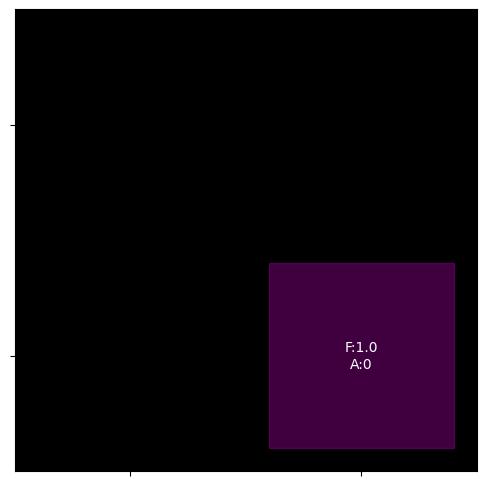

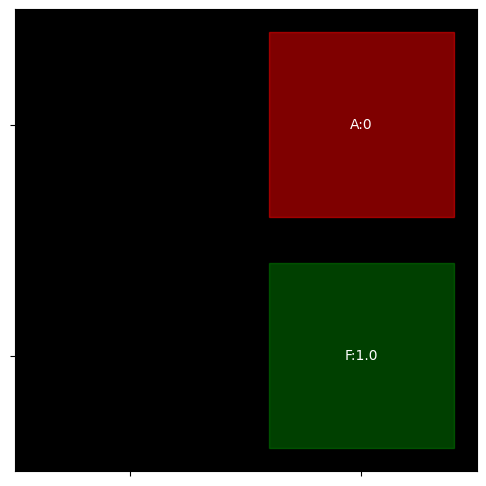

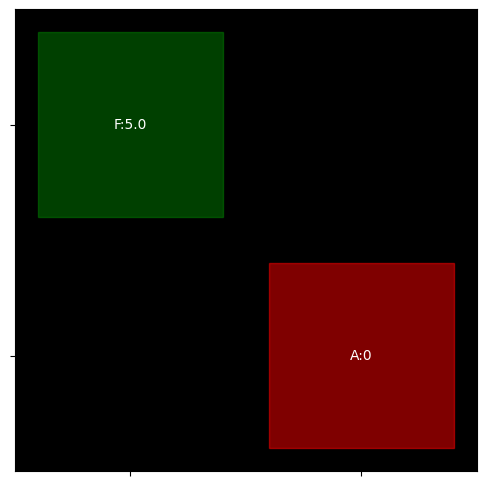

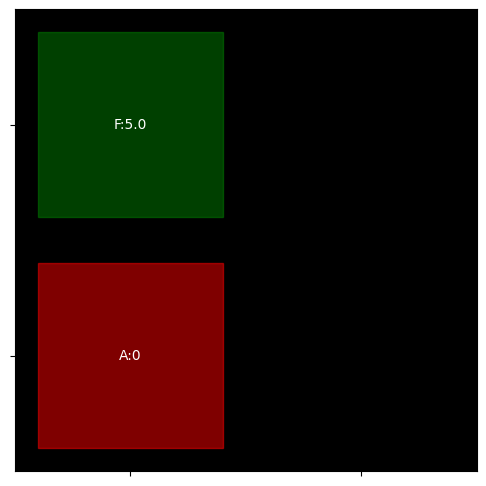

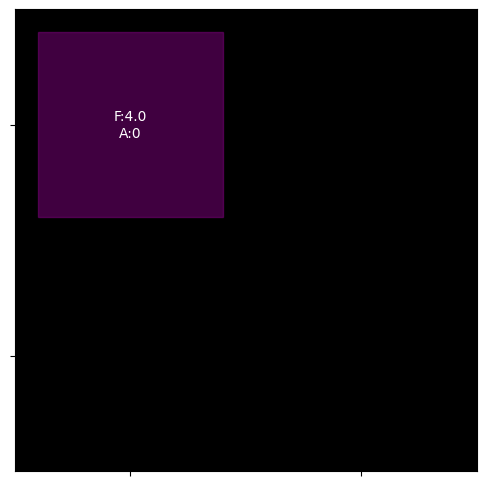

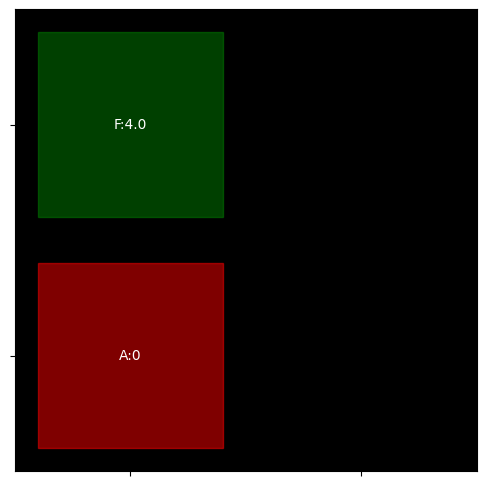

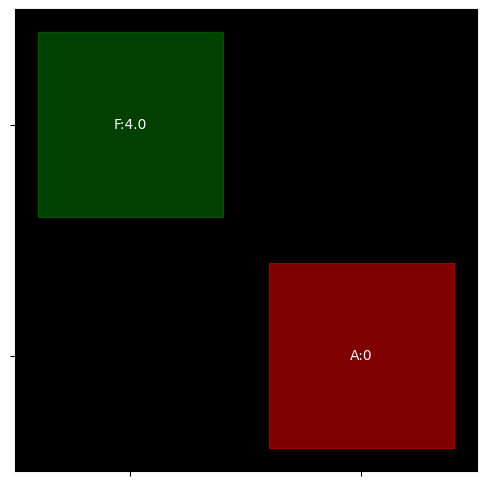

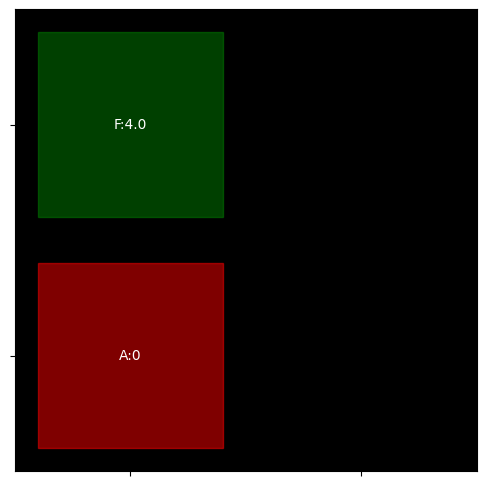

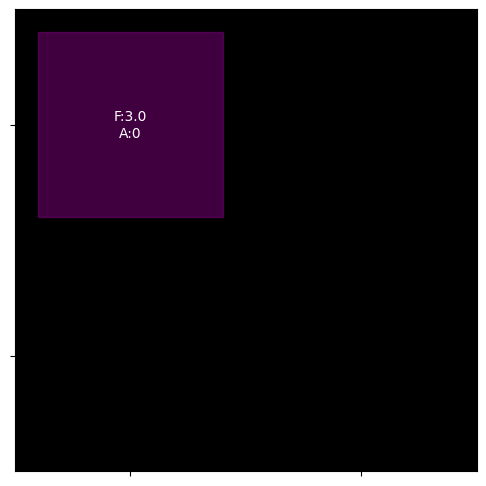

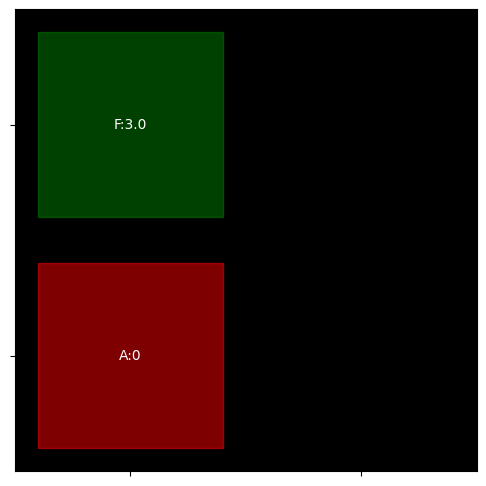

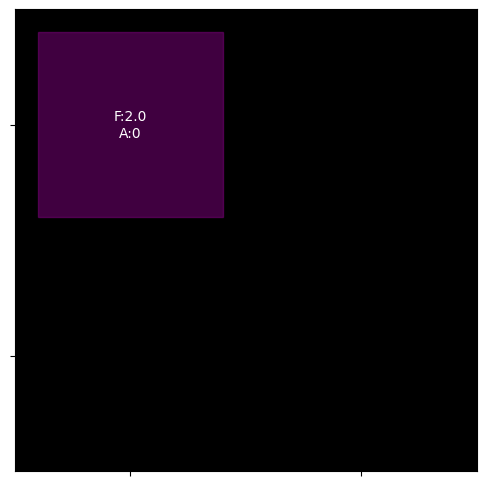

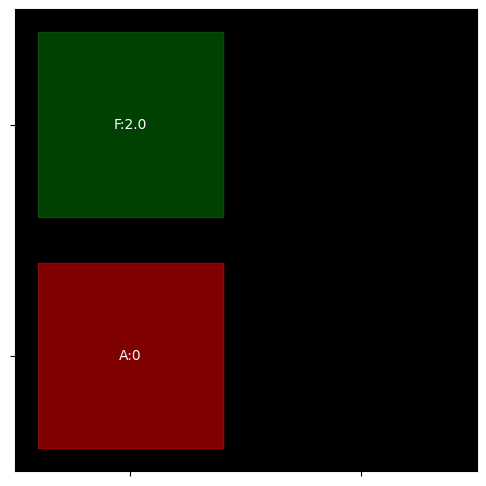

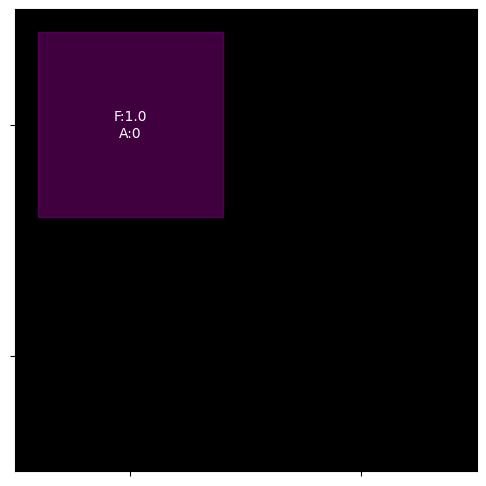

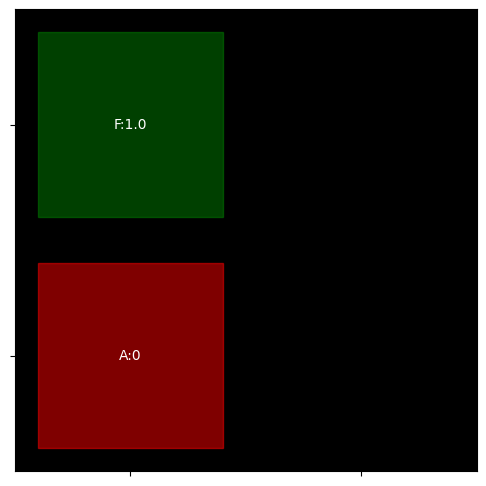

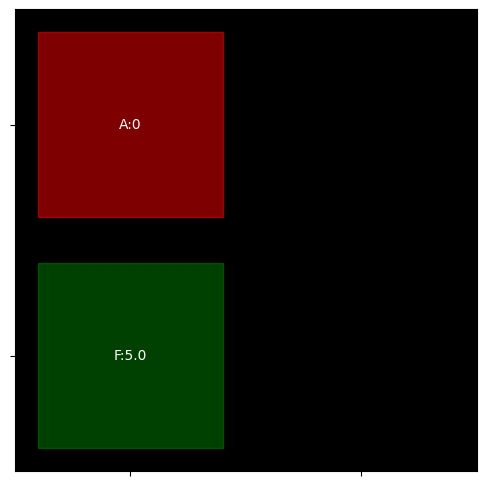

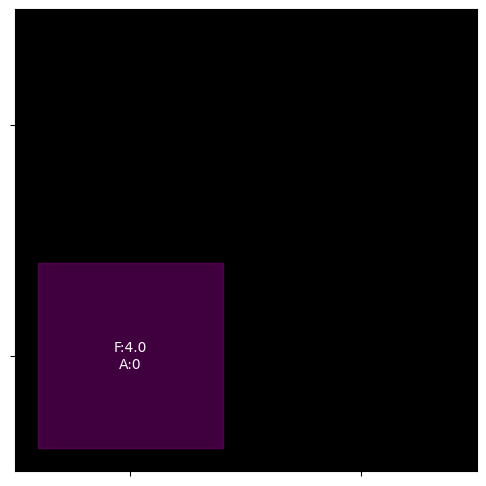

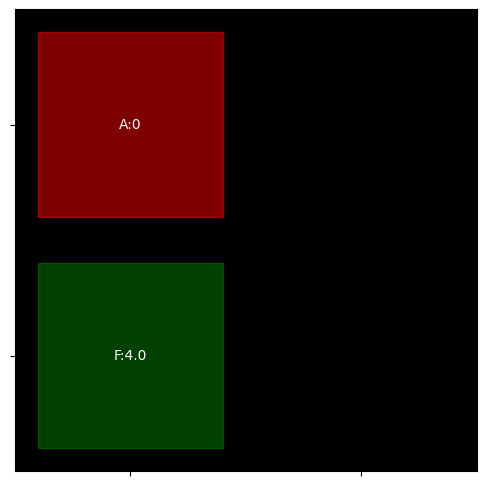

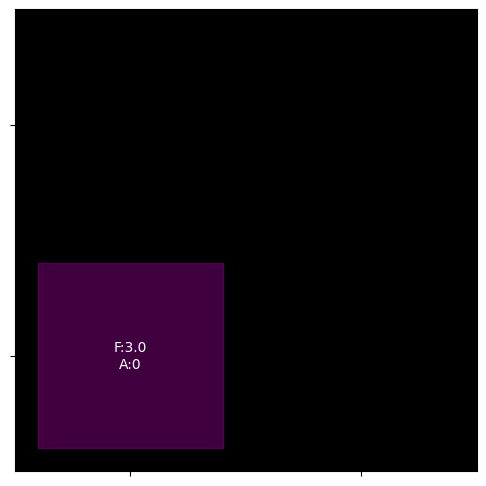

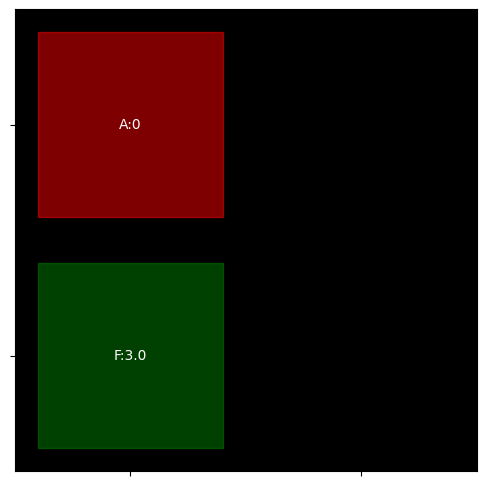

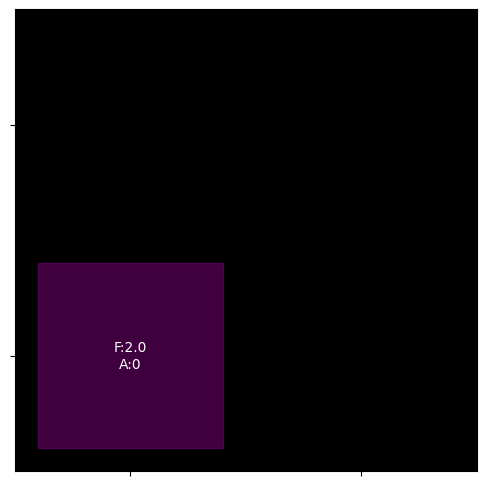

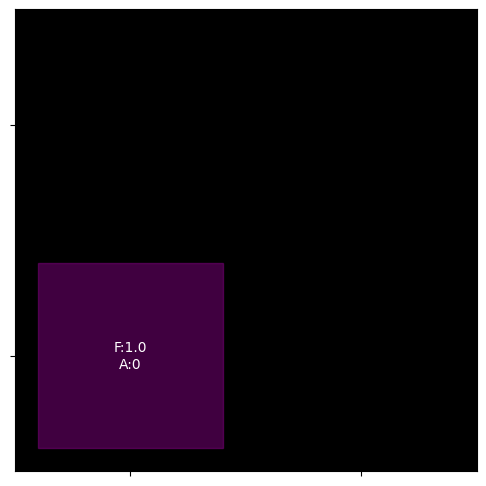

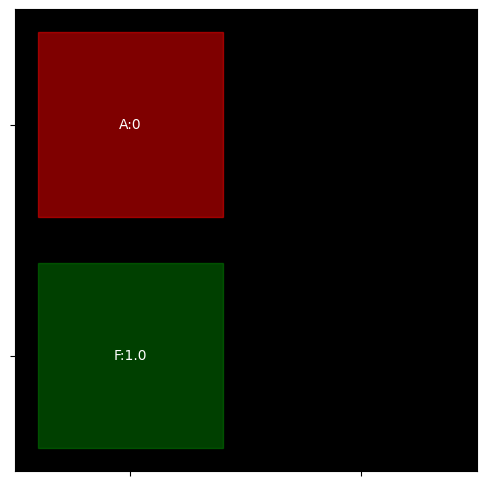

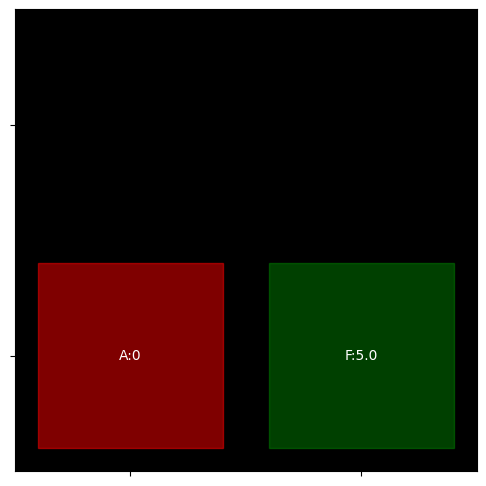

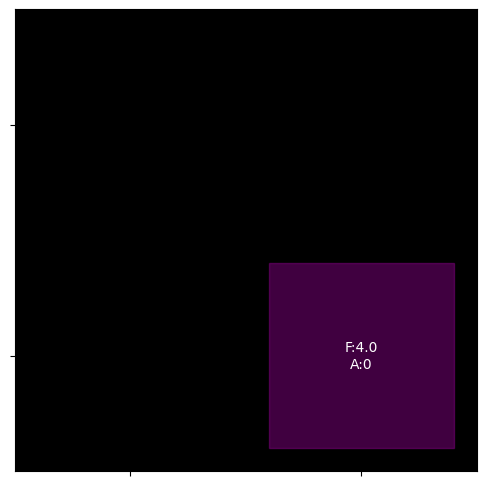

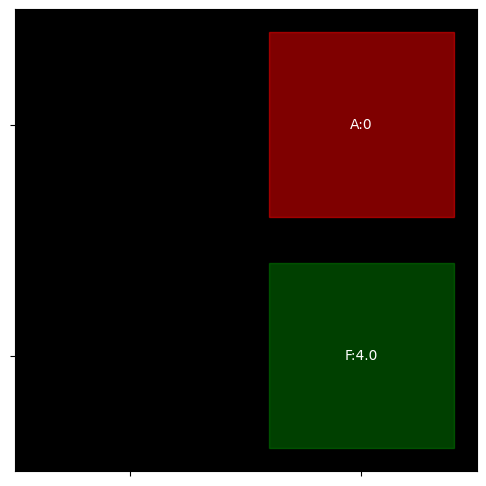

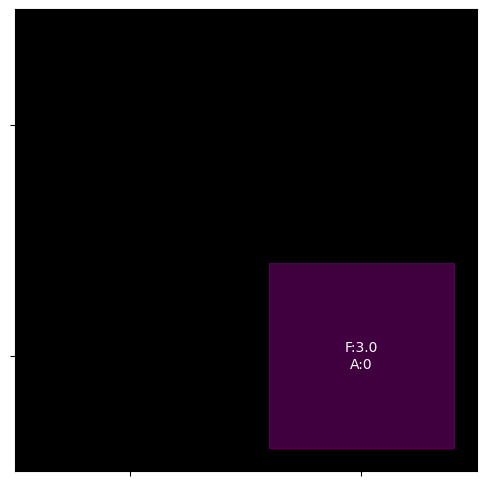

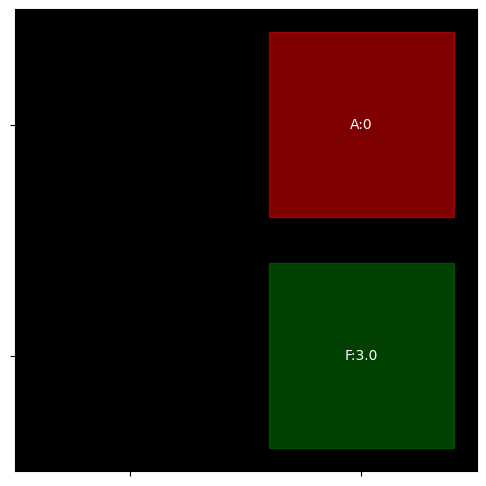

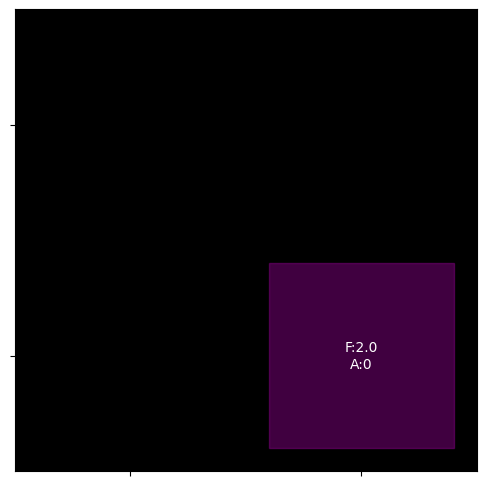

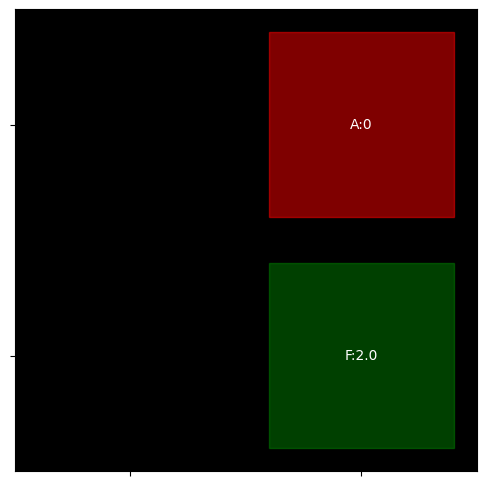

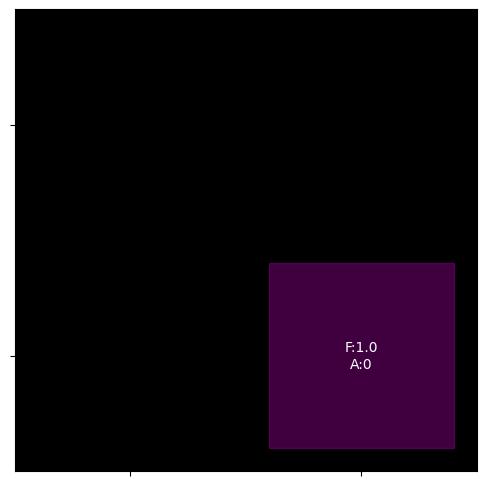

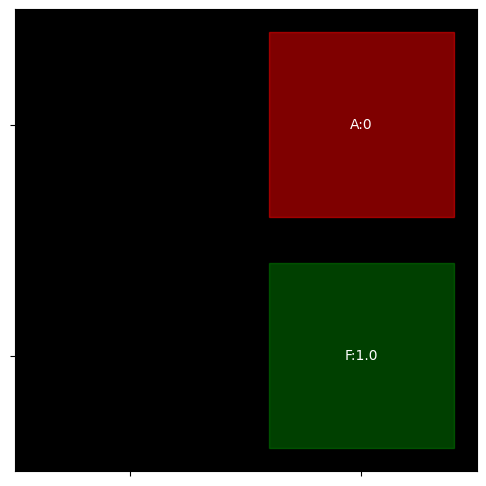

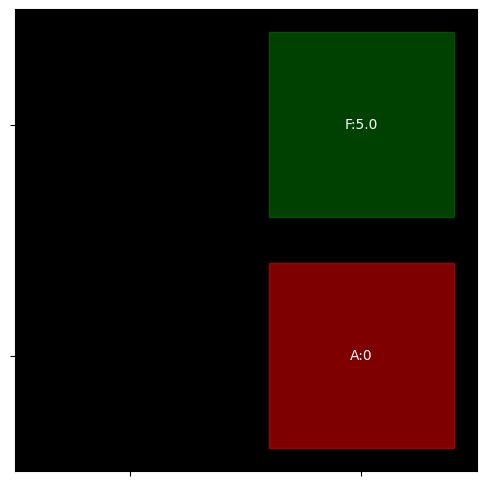

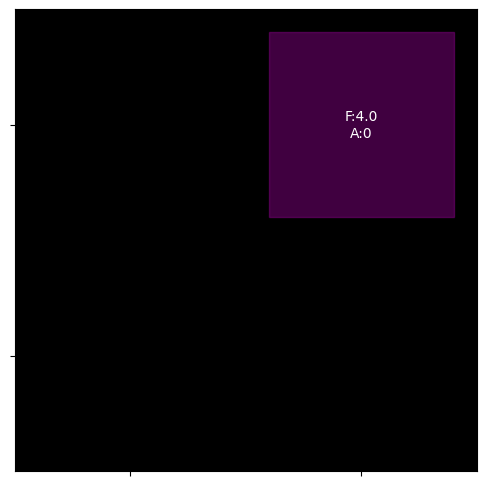

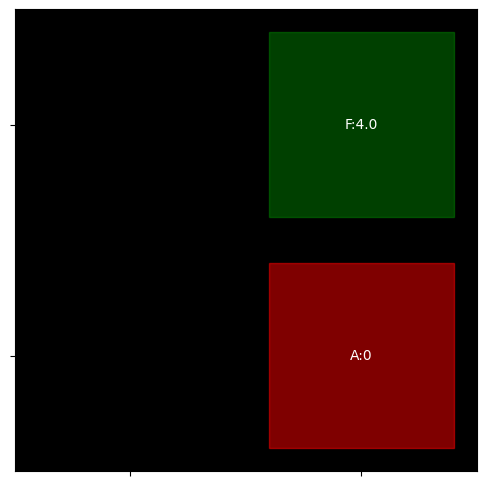

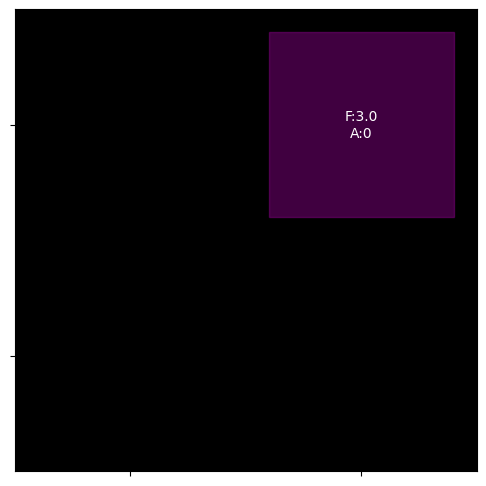

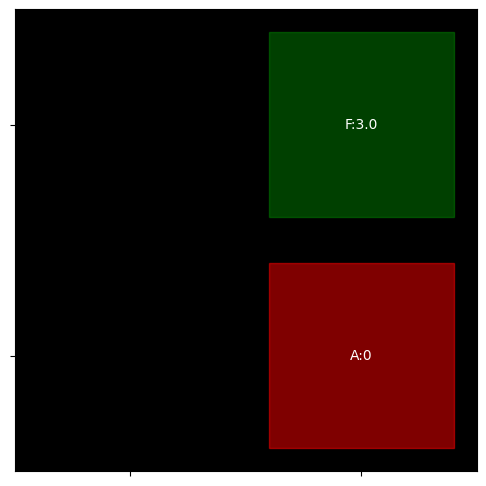

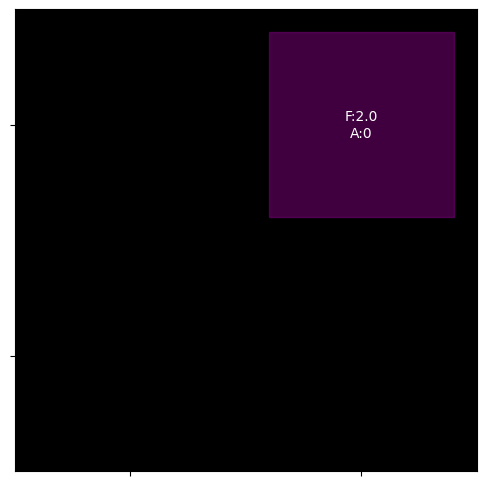

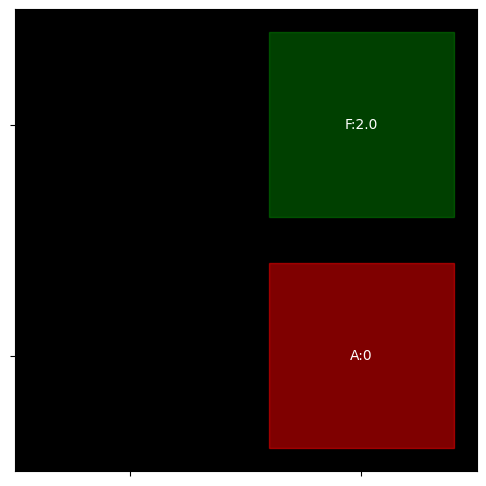

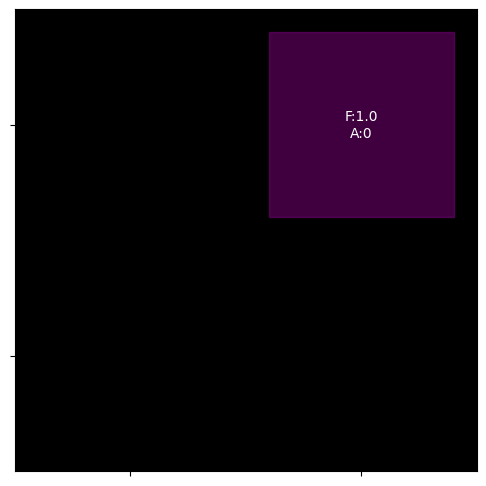

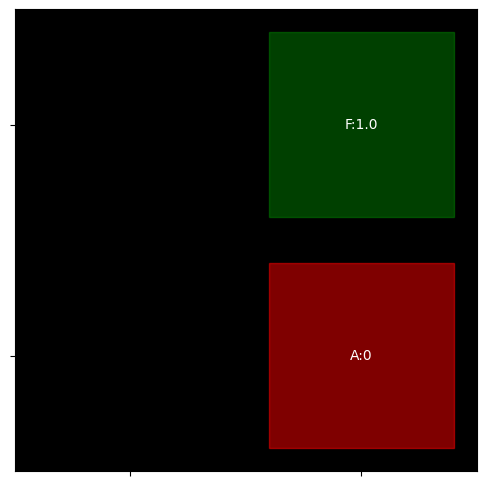

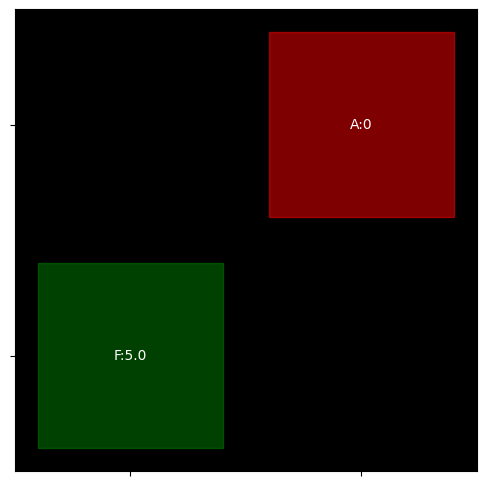

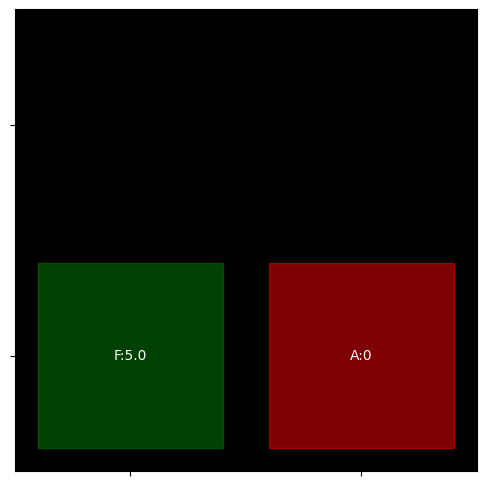

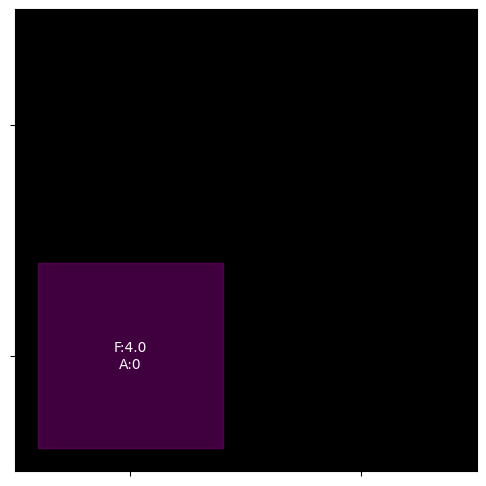

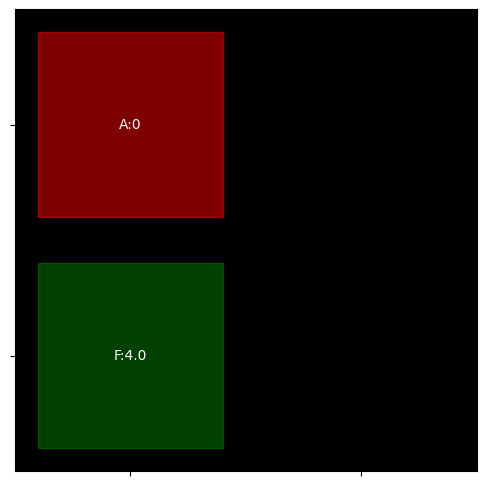

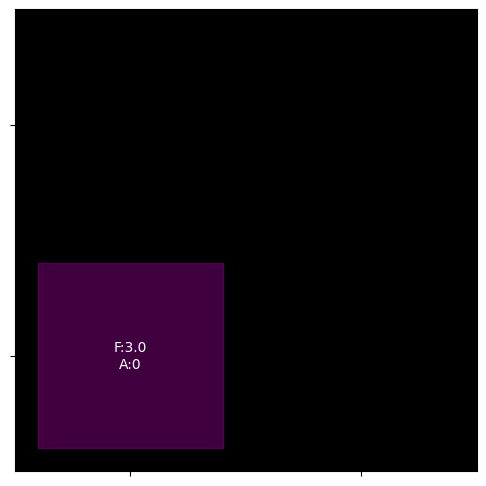

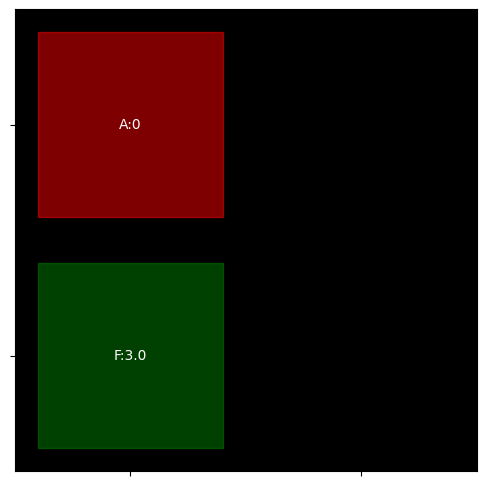

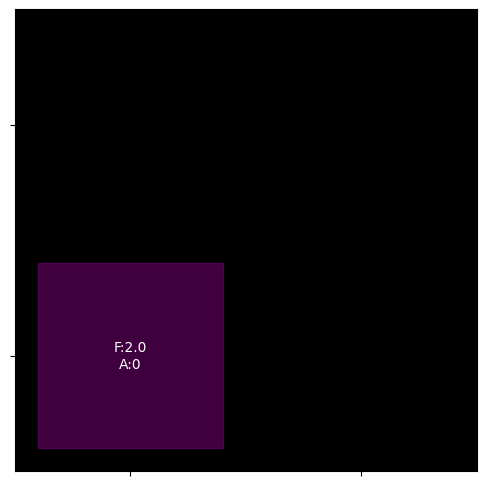

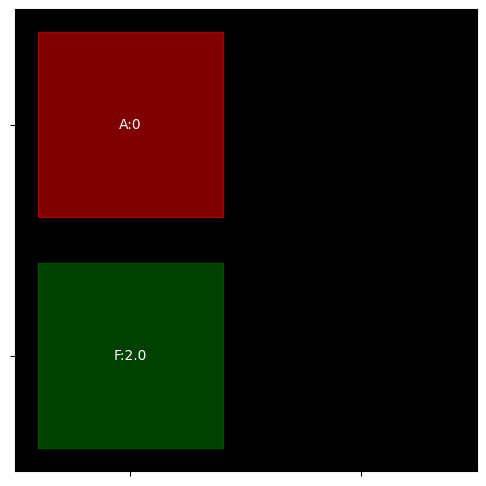

100%|██████████| 125/125 [41:51<00:00, 20.10s/it]


In [ ]:
# ==== Run training Loop ====
# ---- Hyperparameters
env = gym.make('Hierarchy_Grid')
n_actions = env.action_space.n
state_shape = env.observation_space
max_time = 75
Np = env.num_agents
Neps = 125

# ---- Results variables
returns1 = {name: 0 for name in range(env.num_agents)}
returns = []
sum_returns = []
num_fights = []
losses1 = []
losses = []
players = []
num_fights = []
num_steps = []


# ---- Create agents
players = []
for i in range(Np):
    players.append(DQNAgent((2, 2, 2), n_actions))

# ---- model training/visualization loop

for eps in tqdm(range(Neps)):
    eps_returns = []
    state, _ = env.reset()
    timestep = 0
    players[0].update_eps()

    #for p in range(Np):
      #  players[p].update_eps()

    # while not env.good_game: # not ideal for learning & won't give us the return value we want at the end
    while timestep < max_time:

        #env.render()
        action = []
        # get actions of all agents
        for p in range(Np):
            action.append(players[p].act(state[p]))
        next_state, reward, terminations, _ = env.step(action)  # we need reward to be a list of size Np

        # Update returns
        for p in range(Np):
            returns1[p] += reward[p]
            eps_returns.append(reward[0])
            # train the model in each step
            # agent_state = state[p]
            players[p].update(state[p], action[p], reward[p], next_state[p])

        state = next_state

        if eps == Neps - 1:
          env.render()

        timestep += 1

    losses.append(np.mean(players[0].loss[-max_time:]))
    returns.append(np.mean(eps_returns))
    num_fights.append(env.num_fights)
    num_steps.append(timestep)

    # Save model weights
    for n, model in enumerate(players):
        model.save(f'Weights - Agent {n}')

    # train the model by replay, leverages memory
    '''batch_size = 32  # try a larger batch size for better stability and efficiency
    for p in range(Np):
        players[p].replay(batch_size)'''

losses1 = {name: agent.loss for name, agent in enumerate(players)}



In [ ]:
print(returns)

[-0.30666666666666664, 0.18666666666666668, -0.09333333333333334, -0.44, -1.12, -0.49333333333333335, -0.36, 0.9466666666666667, 0.52, -0.02666666666666667, 1.0133333333333334, 1.32, 0.49333333333333335, 0.49333333333333335, 0.29333333333333333, -0.8, 0.06666666666666667, 1.52, 0.013333333333333334, 0.02666666666666667, 0.30666666666666664, -0.4266666666666667, 0.26666666666666666, 0.25333333333333335, 0.02666666666666667, 0.6666666666666666, 0.52, 1.08, 0.76, 0.92, -0.21333333333333335, 0.8533333333333334, -0.13333333333333333, -0.84, 0.9733333333333334, 1.04, 0.06666666666666667, 0.52, 1.3066666666666666, -0.7466666666666667, 0.9333333333333333, 0.48, 0.8933333333333333, 0.6133333333333333, 0.6933333333333334, 1.16, 0.26666666666666666, -0.5066666666666667, 0.8533333333333334, 0.7466666666666667, 0.30666666666666664, 1.04, 0.44, 0.6533333333333333, 0.37333333333333335, 1.0933333333333333, 0.52, 0.02666666666666667, 1.5866666666666667, -0.21333333333333335, 0.64, 1.0266666666666666, 1

In [ ]:
# plt.plot(returns1.values())
# plt.xlabel('episode')
# plt.ylabel('return')

Text(0, 0.5, 'return')

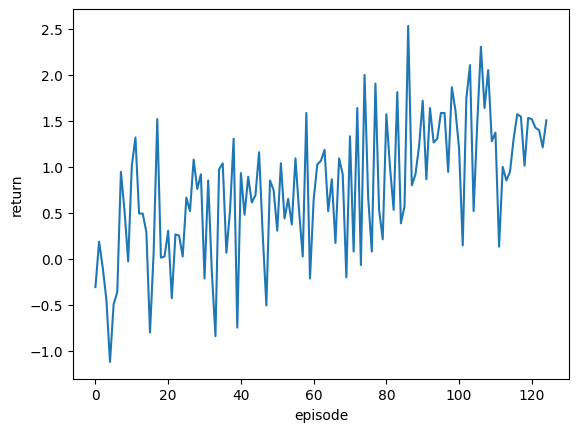

In [ ]:
plt.plot(returns)
plt.xlabel('episode')
plt.ylabel('return')

Text(0, 0.5, 'Median Squared Loss (Median across agents)')

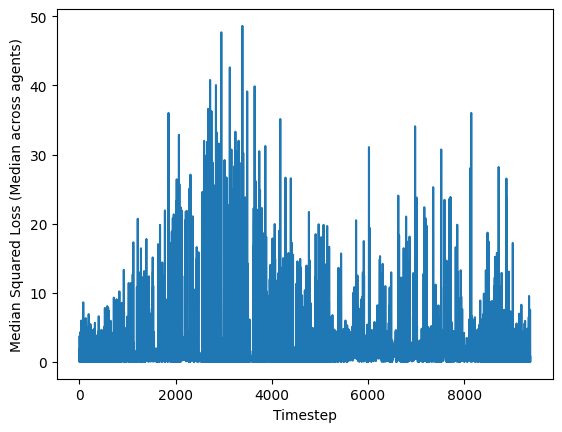

In [ ]:
mean_loss = []

for loss in losses1.values():
    loss = list(loss)

    mean_loss.append(loss)

mean_loss = np.stack(mean_loss)
median_loss = np.median(mean_loss, axis=0)

plt.plot(median_loss)

plt.xlabel('Timestep')
plt.ylabel('Median Squared Loss (Median across agents)')


Text(0, 0.5, 'Mean Squared Loss (Mean across agents)')

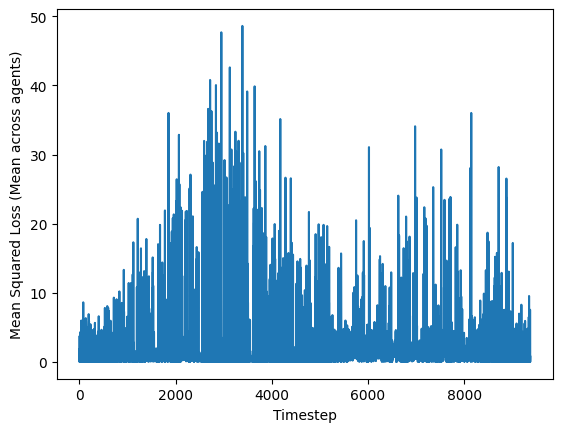

In [ ]:
mean_loss = np.mean(mean_loss, axis=0)
plt.plot(mean_loss)

plt.xlabel('Timestep')
plt.ylabel('Mean Squared Loss (Mean across agents)')

In [ ]:
import os
import tensorflow as tf
import keras

model.save(r'C:\Users\maxhe\OneDrive\Dokumente\Uni_Berlin\Vl,Seminare_etc\8. Sommersemester 2023\NMA\saved')


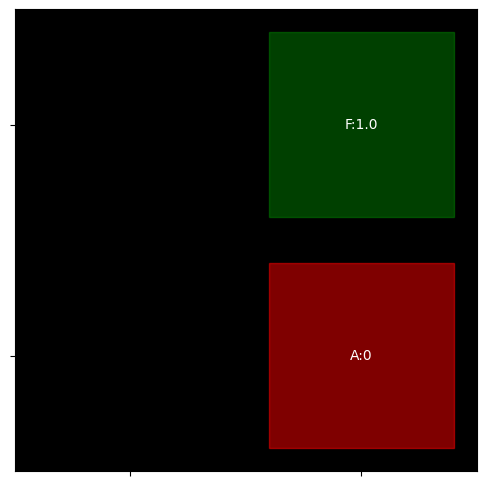

In [ ]:
# action = []
# # get actions of all agents
# for p in range(Np):
#     action.append(players[p].act(state))

# state, reward, terminations, _, _ = env.step(action)

env.render()